In [1]:
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    BitsAndBytesConfig
)
from datasets import Dataset, load_dataset
import torch
import random
import pandas as pd
import nltk
import ast
import statistics
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
f = pd.read_csv('/home/gridsan/arunas/broca/mistral/mistral-outputs/classification-train-test-det.csv')
ft = pd.read_csv('/home/gridsan/arunas/broca/mistral/mistral-outputs/translation-train-test-det.csv')

g = pd.read_csv('/home/gridsan/arunas/broca/mistral/mistral-outputs/classification-train-test-acc.csv')
gt = pd.read_csv('/home/gridsan/arunas/broca/mistral/mistral-outputs/translation-train-test-acc.csv')

In [3]:
f.drop(['Unnamed: 0'], axis='columns', inplace=True)
ft.drop(['Unnamed: 0'], axis='columns', inplace=True)

In [4]:
f['type'].unique()

array(['sentence', 'subordinate-sentence', 'passive-sentence', 'it',
       'it-r-1-null_subject', 'it-r-2-passive', 'it-r-3-subordinate',
       'it-u-1-negation', 'it-u-2-invert', 'it-u-3-gender', 'jp-r-1-sov',
       'jp-r-2-passive', 'jp-r-3-subordinate', 'jp-u-1-negation',
       'jp-u-2-invert', 'jp-u-3-past-tense'], dtype=object)

In [5]:
for col in ft['type'].unique():
    print(col, statistics.mean(ft[ft['type'] == col]['bleu']))

sentence 0.9420352880263267
subordinate-sentence 0.7198754917808781
passive-sentence 0.950557900395033
it 0.8338438947767786
it-r-1-null_subject 0.8118105247360313
it-r-2-passive 0.847437660463566
it-r-3-subordinate 0.687043018405661
it-u-1-negation 0.8522902025019463
it-u-2-invert 0.8420219109132052
it-u-3-gender 0.7737602291964664
jp-r-1-sov 0.9339018327536458
jp-r-2-passive 0.8907824580200415
jp-r-3-subordinate 0.7747333340998827
jp-u-1-negation 0.9406008414316391
jp-u-2-invert 0.9316059439208586
jp-u-3-past-tense 0.6865444431142693


20


<Figure size 800x640 with 0 Axes>

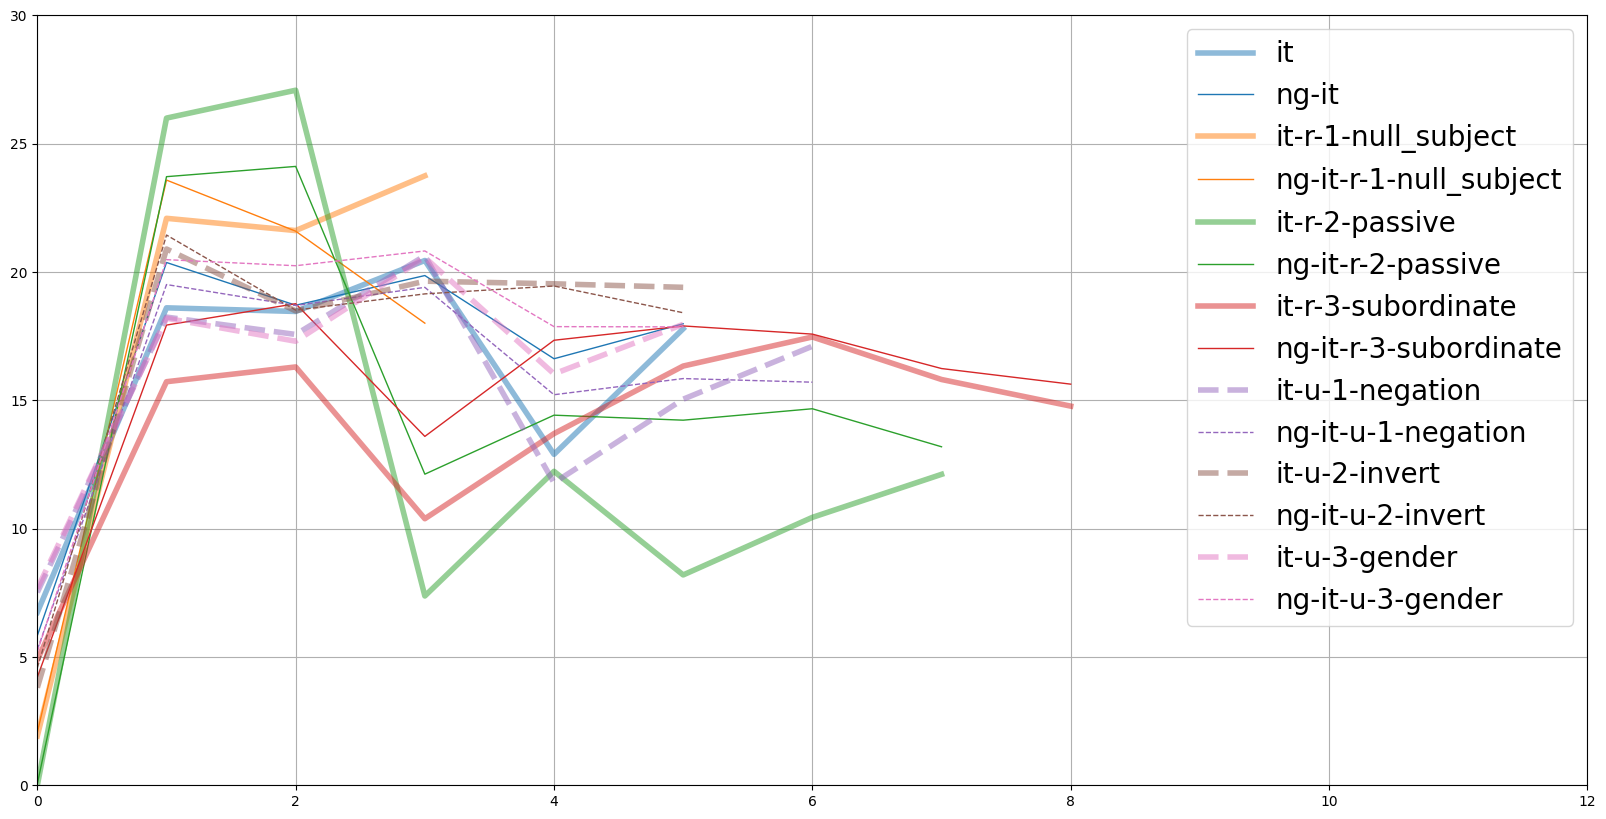

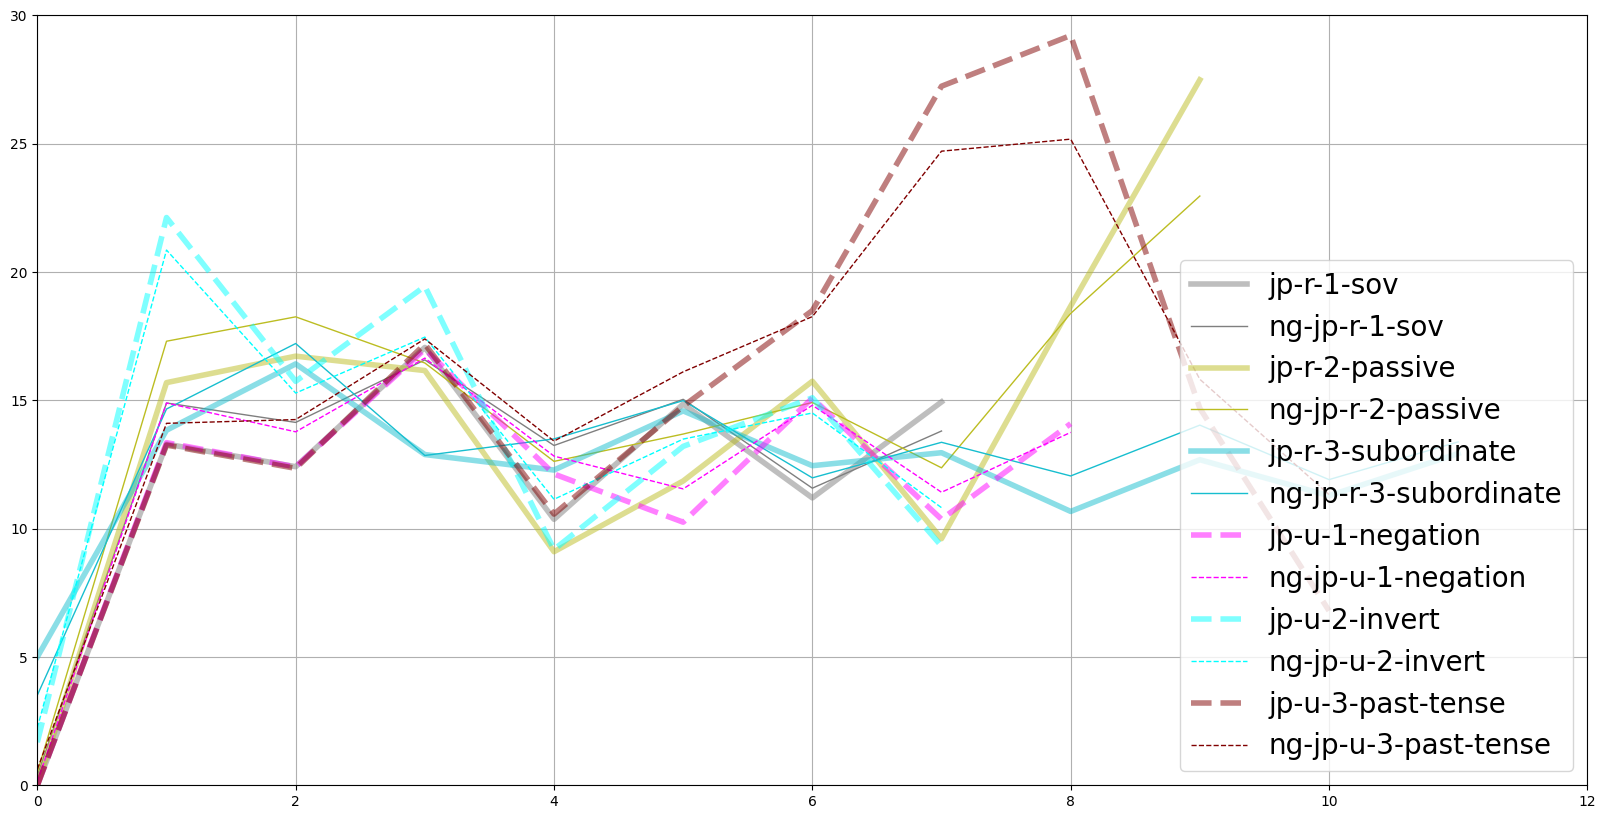

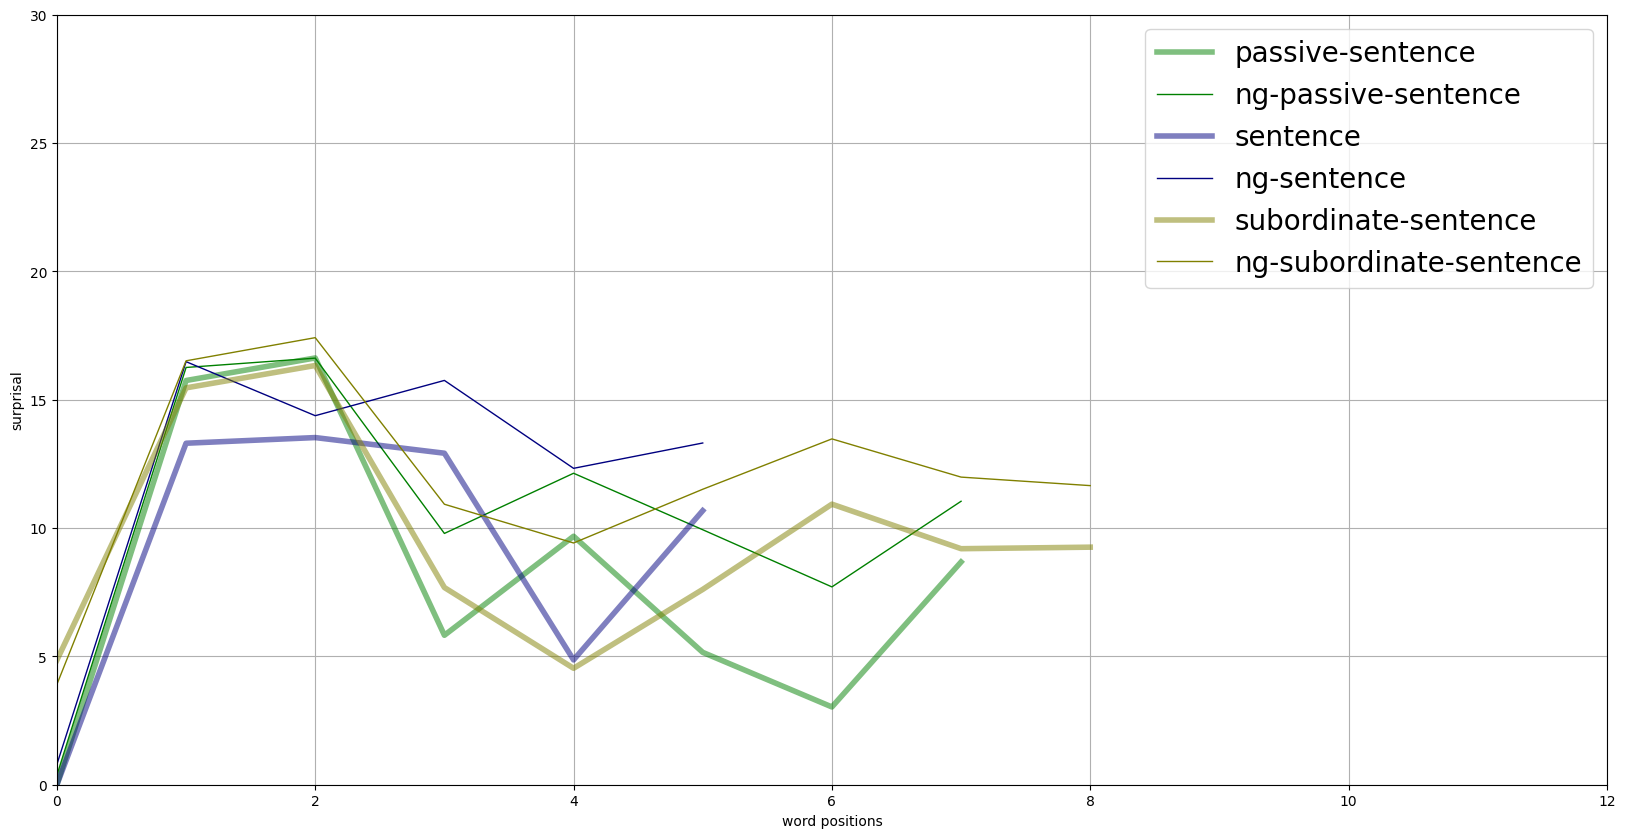

In [6]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)
x = list(range(12))
ifig,iax=plt.subplots(figsize=(20, 10))
jfig,jax=plt.subplots(figsize=(20, 10))
efig,eax=plt.subplots(figsize=(20, 10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#ff00ff',
          '#00ffff', '#800000', '#008000', '#000080', '#808000',
          '#800080', '#008080', '#808080', '#c0c0c0']
print(len(colors))
count = 0
for sent_type in sorted(f['type'].unique()):
    surps = []
    ng_surps = []
    for idx, row in f[(f['type'] == sent_type) & (f['gold'] == 'Yes')].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)

    transformed_surps = np.array([list(zip(*surps))[i] for i in list(range(max([len(e) for e in surps])))])
    # print(transformed_surps)
    avg_surp = np.mean(transformed_surps, axis=1)

    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 20}

    matplotlib.rc('font', **font)
    y = avg_surp.tolist()
    for i in range(len(y), len(x)): 
        y.append(np.nan)  # Adding missing values
    nan_indices = [index for index, value in enumerate(y) if np.isnan(value)]
    nan_x = [i for i in nan_indices]
    nan_y = [0 for i in nan_indices]
    # print(len(y), len(x), nan_indices)
    if 'it' in sent_type[:2]:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            iax.plot(x, y, '--', label=sent_type, linewidth=4, alpha=0.5, color=colors[count])
        else:
            iax.plot(x, y, label=sent_type, linewidth=4, alpha=0.5, color=colors[count])
    elif 'jp' in sent_type[:2]:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            jax.plot(x, y, '--', label=sent_type,linewidth=4, alpha=0.5, color=colors[count])
        else:
            jax.plot(x, y, label=sent_type, linewidth=4, alpha=0.5, color=colors[count])
    else:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            eax.plot(x, y, '--', label=sent_type, linewidth=4, alpha=0.5, color=colors[count])
        else:
            eax.plot(x, y, label=sent_type, linewidth=4, alpha=0.5, color=colors[count])

    for idx, row in f[(f['type'] == sent_type) & (f['gold'] == 'No')].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        ng_surps.append(myList)

    transformed_ng_surps = np.array([list(zip(*ng_surps))[i] for i in list(range(max([len(e) for e in ng_surps])))])
    # print(transformed_ng_surps)
    avg_ng_surp = np.mean(transformed_ng_surps, axis=1)

    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 20}

    matplotlib.rc('font', **font)
    y = avg_ng_surp.tolist()
    for i in range(len(y), len(x)): 
        y.append(np.nan)  # Adding missing values
    nan_indices = [index for index, value in enumerate(y) if np.isnan(value)]
    nan_x = [i for i in nan_indices]
    nan_y = [0 for i in nan_indices]
    # print(len(y), len(x), nan_indices)
    if 'it' in sent_type[:2]:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            iax.plot(x, y, '--', label=f'ng-{sent_type}', linewidth=1, color=colors[count])
        else:
            iax.plot(x, y, label=f'ng-{sent_type}', linewidth=1, color=colors[count])
    elif 'jp' in sent_type[:2]:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            jax.plot(x, y, '--', label=f'ng-{sent_type}',linewidth=1, color=colors[count])
        else:
            jax.plot(x, y, label=f'ng-{sent_type}', linewidth=1, color=colors[count])
    else:
        if len(sent_type) > 3 and 'u' == sent_type[3]:
            eax.plot(x, y, '--', label=f'ng-{sent_type}', linewidth=1, color=colors[count])
        else:
            eax.plot(x, y, label=f'ng-{sent_type}', linewidth=1, color=colors[count])
    jax.set_xlim(0, 12)
    jax.set_ylim(0, 30)
    iax.set_xlim(0, 12)
    iax.set_ylim(0, 30)
    eax.set_xlim(0, 12)
    eax.set_ylim(0, 30)
    count += 1
    

plt.xlim(0, 12)
plt.ylim(0, 30)
plt.xlabel("word positions")
plt.ylabel("surprisal")
iax.grid()
jax.grid()
eax.grid()
iax.legend()
jax.legend()
eax.legend()
efig.tight_layout()
jfig.tight_layout()
ifig.tight_layout()
efig.savefig('en-surprisals.png')
jfig.savefig('jp-surprisals.png')
ifig.savefig('it-surprisals.png')
plt.show()

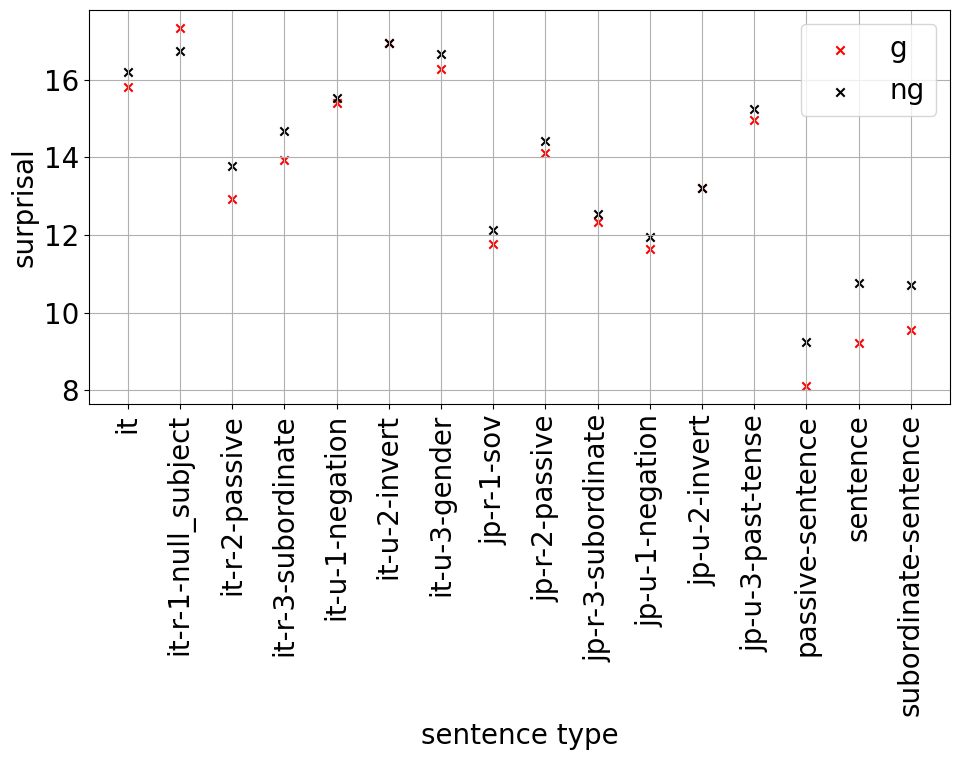

In [8]:
x = []
y = []
x_ug = []
y_ug = []

sfig, ax = plt.subplots(figsize=(10, 8))

for sent_type in sorted(f['type'].unique()):
    surps = []
    for idx, row in f[(f['type'] == sent_type) & (f['gold'] == 'Yes')].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)

    transformed_surps = np.array([list(zip(*surps))[i] for i in list(range(max([len(e) for e in surps])))])
    avg_surp = np.mean(transformed_surps)
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 20}

    x.append(f'{sent_type}')
    y.append(avg_surp)

    for idx, row in f[(f['type'] == sent_type) & (f['gold'] == 'No')].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)

    transformed_surps = np.array([list(zip(*surps))[i] for i in list(range(max([len(e) for e in surps])))])
    avg_surp = np.mean(transformed_surps)
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 20}

    x_ug.append(f'{sent_type}')
    y_ug.append(avg_surp)

plt.grid()
matplotlib.rc('font', **font)
plt.scatter(x,y, marker='x', color='red', label='g')
plt.scatter(x_ug,y_ug, marker='x', color='black', label='ng')
plt.xlabel("sentence type")
plt.xticks(rotation=90)
plt.ylabel("surprisal")
plt.legend()
sfig.tight_layout()
sfig.savefig('surprisals_avg.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6


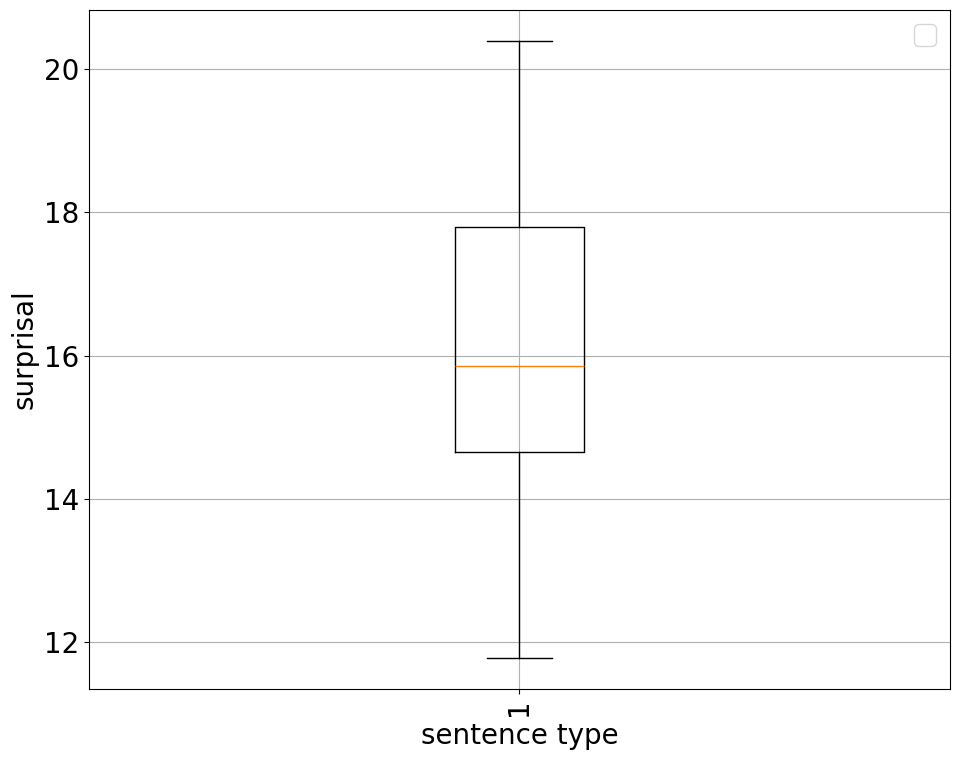

In [43]:
x = []
y = []
x_ug = []
y_ug = []

sfig, ax = plt.subplots(figsize=(10, 8))

for sent_type in sorted(f['type'].unique()):
    surps = []
    for idx, row in f[(f['type'] == sent_type) & (f['gold'] == 'Yes')].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)
    x.append(f'{sent_type}')
    y.append(surps)

    for idx, row in f[(f['type'] == sent_type) & (f['gold'] == 'No')].iterrows():
        myList = []
        for i in list(ast.literal_eval(row['surprisal'])):
            myList.append(i[1])
        surps.append(myList)

    transformed_surps = np.array([list(zip(*surps))[i] for i in list(range(max([len(e) for e in surps])))])
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 20}

    x_ug.append(f'{sent_type}')
    y_ug.append(surps)

plt.grid()
matplotlib.rc('font', **font)
plt.boxplot(y[0][0])
print(len(y[0][0]))
# plt.boxplot(x_ug,y_ug)
plt.xlabel("sentence type")
plt.xticks(rotation=90)
plt.ylabel("surprisal")
plt.legend()
sfig.tight_layout()
# sfig.savefig('surprisals_avg.png')
plt.show()